2.2 Action-Value Methods

We begin by looking more closely at some simple methods for estimating the
values of actions and for using the estimates to make action selection decisions.
In this chapter, we denote the true (actual) value of action $a$ as $q(a)$, and the
estimated value on the $t$th time step as $Q_{t}(a)$. Recall that the true value of an
action is the mean reward received when that action is selected. One natural
way to estimate this is by averaging the rewards actually received when the
action was selected. In other words, if by the $t$th time step action $a$ has been
chosen $N_{t}(a)$ times prior to $t$, yielding rewards $R_{1}, R_{2}, . . . ,R_{N_{t}(a)}$
, then its value
is estimated to be

$Q_{t}(a) = \frac{R_{1}+R_{2}+...+R_{N_{t}(a)}}{N_{t}(a)} $

In [3]:
def sample_average(R):
    return sum(R)/len(R)

If $N_{t}(a) = 0$, then we define $Q_{t}(a)$ instead as some default value, such as
$Q_{1}(a) = 0$. As $N_{t}(a) → \infty$, by the law of large numbers, $Q_{t}(a)$ converges
to $q(a)$. We call this the sample-average method for estimating action values
because each estimate is a simple average of the sample of relevant rewards.
Of course this is just one way to estimate action values, and not necessarily
the best one. Nevertheless, for now let us stay with this simple estimation
method and turn to the question of how the estimates might be used to select
actions.

The simplest action selection rule is to select the action (or one of the actions) with highest estimated action value, that is, to select at step $t$ one of the greedy actions, $A^{∗}_{t}$, for which $Q_{t}(A^{∗}_{t})= max_{a}Q_{t}(a)$. This greedy action
selection method can be written as

$A^{*}_{t} = argmax_{a}Q_{t}(a)$

In [4]:
import random
def greedy_policy(Q):
    #returns the greedy action according to Q
    #Q: a dictionary, where keys are action and values are the rewards we've collected for action a so far. 
    #We record a list of best actions, so that ties are broken randomly
    best_actions = [None]
    best_value = float('-inf')
    for a in Q.keys(): #for each action in Q
        av_reward = sample_average(Q[a])
        if av_reward > best_value: #take on action if it's at least as good
            best_actions = [a]
            best_value = av_reward
        elif av_reward == best_value: #add action to list
            best_actions.append(a)
    
    return(random.choice(best_actions))

where $argmax_{a}$ denotes the value of $a$ at which the expression that follows
is maximized (with ties broken arbitrarily). Greedy action selection always exploits current knowledge to maximize immediate reward; it spends no time at all sampling apparently inferior actions to see if they might really be better. A simple alternative is to behave greedily most of the time, but every once in a while, say with small probability $\epsilon$, instead to select randomly from amongst all the actions with equal probability independently of the action value estimates. We call methods using this near-greedy action selection rule $\epsilon$-greedy methods. An advantage of these methods is that, in the limit as the number of plays increases, every action will be sampled an infinite number of times, guaranteeing that $N_{t}(a) → \infty$ for all $a$, and thus ensuring that all
the $Q_{t}(a)$ converge to $q(a)$. This of course implies that the probability of selecting the optimal action converges to greater than 1 − $\epsilon$, that is, to near
certainty. These are just asymptotic guarantees, however, and say little about the practical effectiveness of the methods

In [5]:
import random

def epsilon_greedy_policy(Q,epsilon):
    #returns the epsilon-greedy action according to Q
    population = [greedy_policy(Q),random.choice(list(Q.keys()))] #[greedy,random]
    weights = [1-epsilon,epsilon]
    return random.choices(population,weights)[0]

To roughly assess the relative effectiveness of the greedy and $\epsilon$-greedy methods, we compared them numerically on a suite of test problems. This was a set of 2000 randomly generated n-armed bandit tasks with $n = 10$. For each bandit, the action values, $q(a)$, $a = 1, . . . , 10$, were selected according to a normal (Gaussian) distribution with mean 0 and variance 1. On $t$th time step with a given bandit, the actual reward $R_{t}$ was the $q(A_{t})$ for the bandit (where $A_{t}$ was the action selected) plus a normally distributed noise term that was mean 0 and variance 1. Averaging over bandits, we can plot the performance and behavior of various methods as they improve with experience over 1000 steps. We call this suite of test tasks the 10-armed testbed.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def ten_armed_testbed(num_arms=10,num_bandits=1000,steps=500,epsilons=[0.1,0.01,0.0]):
    #implementing the ten armed testbed for epsilon greedy policy. For each setting of epsilon, we do num_bandit experiments an average over them. 
    av_rewards = {} #dictionary, keys are epsilon, value will be list of average reward across time steps
    opt_actions = {} #dictionary, keys are epsilon, value will be list of percent of actions which were optimal across time steps
    
    for epsilon in epsilons: #for each epsilon
        av_reward = [] #will contain a list of rewards at each time step for each bandit
        opt_action = [] #will contain whether action at each time step for each bandit was optimal
        for bandit in tqdm(range(num_bandits)): 
            rewards = [] #will collect the rewards
            actions = [] #will collect whether action optimal or not
            #Rewards collected from each action, which we call Q(a) (although we need to average it in order for it to be Q(a) as described above)
            Q = {a:[0] for a in range(num_arms)} #we initialize the first return of all actions to 0 so greedy policy selection is happy
            
            #generate the bandit, q(a)
            q = np.random.normal(0,1,num_arms)
            #figure out optimal action
            max_v = max(q) #max value
            max_a = [i for i,j in enumerate(q) if j == max_v][0] #get argmax action
            for step in range(steps): #simulate the bandit
                action = epsilon_greedy_policy(Q,epsilon)
                reward = q[action] + np.random.normal(0,1) #add noise to the reward
                #append reward to rewards
                rewards.append(reward)
                #append reward to estimation
                Q[action].append(reward)
                #check if action was optimal
                actions.append(1 if action == max_a else 0)
            av_reward.append(rewards)
            opt_action.append(actions)
        #average the rewards and optimal actions across all the bandits for each time step. python magic
        epsilon_av_reward = list(map(sample_average, zip(*av_reward)))
        epsilon_opt_action = list(map(sample_average, zip(*opt_action)))
        av_rewards[epsilon] = epsilon_av_reward
        opt_actions[epsilon] = epsilon_opt_action
        
    #Visualize the results
    plt.plot(range(len(av_rewards[0.1])),av_rewards[0.1],c='black')
    plt.plot(range(len(av_rewards[0.01])),av_rewards[0.01],c='red')
    plt.plot(range(len(av_rewards[0.0])),av_rewards[0.0],c='green')
    plt.show()
    plt.plot(range(len(opt_actions[0.1])),opt_actions[0.1],c='black')
    plt.plot(range(len(opt_actions[0.01])),opt_actions[0.01],c='red')
    plt.plot(range(len(opt_actions[0.0])),opt_actions[0.0],c='green')
    plt.show()

100%|██████████| 1000/1000 [00:25<00:00, 39.26it/s]


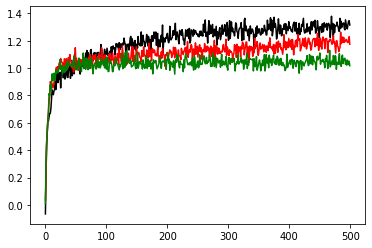

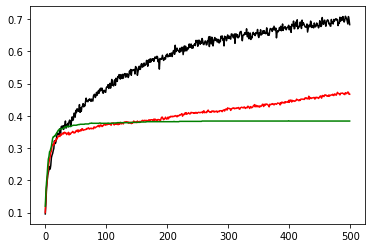

In [7]:
ten_armed_testbed()

Picture of average reward
<img src="./av_reward.png">

Picture of optimal action percentage
<img src="./optimal_action.png">